# NLP: Search Engine

In [1]:
from nltk.tokenize import word_tokenize
import sqlite3

conn = sqlite3.connect('news.db')
cur = conn.cursor()


def 어절(sentence, n=2):
    tokens = word_tokenize(sentence)
    return [
        tuple(tokens[token:token + n])
        for token in range(len(tokens) - (n - 1))
    ]


def 음절(sentence, n=2):
    tokens = list(sentence)
    return [''.join(tokens[i:i + n]) for i in range(len(tokens))]

In [2]:
query = """
    SELECT id, url, content, date
    FROM news;
"""
cur.execute(query)
corpus = cur.fetchall()
corpus = [news[2] for news in corpus]

---

In [3]:
import re
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
pattern1 = re.compile(f'{re.escape(punctuation)}')
pattern2 = re.compile(r'[A-Za-z]{5,}')
pattern3 = re.compile(r'[^ 0-9A-Za-z가-힣]')
pattern4 = re.compile(r'\n{2,}')

In [5]:
collection = [
    pattern4.sub('',
                 pattern3.sub('',
                              pattern2.sub('',
                                           pattern1.sub('', _)))).strip()
    for _ in corpus
]

- Tokenizer (어절, 형태소, ngram)
- ngram: Stemming / Normalization (길이, 빈도) --> stopwording

In [6]:
len(word_tokenize(collection[0])), len(collection[0].split())

(515, 515)

In [7]:
len(collection[0].split()), len(어절(collection[0])), len(음절(collection[0]))

(515, 514, 2146)

In [8]:
from konlpy.tag import Kkma
kkma = Kkma()

C:\Users\u\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [9]:
Vocabulary = []

for _ in collection:
    Vocabulary.extend(_.split())
    Vocabulary.extend(어절(_))
    Vocabulary.extend(음절(_))
    Vocabulary.extend(kkma.morphs(_))

In [10]:
len(Vocabulary), len(set(Vocabulary))

(110740, 28262)

In [11]:
Vocabulary = [_ for _ in list(set(Vocabulary)) if 1 < len(_) < 6]

In [12]:
len(Vocabulary)

26849

In [13]:
BoM = []
for d in collection:
    docVector = [0 for _ in range(len(Vocabulary))]
    BoMCollection = d.split() + 어절(d) + 음절(d) + kkma.morphs(d)
    for _ in BoMCollection:
        if _ in Vocabulary:
            docVector[Vocabulary.index(_)] = 1
    BoM.append(docVector)

BoM의 문제점은 Sparse하다 (복잡도가 증가한다)

In [14]:
[(sum(_), len(Vocabulary) - sum(_)) for _ in BoM]

[(1753, 25096),
 (1753, 25096),
 (1156, 25693),
 (1321, 25528),
 (1745, 25104),
 (1451, 25398),
 (625, 26224),
 (1073, 25776),
 (1387, 25462),
 (1195, 25654),
 (1690, 25159),
 (2229, 24620),
 (1545, 25304),
 (1137, 25712),
 (1825, 25024),
 (1969, 24880),
 (1070, 25779),
 (1089, 25760),
 (933, 25916),
 (1030, 25819),
 (1433, 25416),
 (1274, 25575),
 (1612, 25237),
 (572, 26277),
 (1311, 25538),
 (1359, 25490),
 (1312, 25537),
 (1507, 25342),
 (1644, 25205),
 (976, 25873),
 (1844, 25005),
 (1774, 25075),
 (1074, 25775),
 (945, 25904),
 (848, 26001),
 (635, 26214)]

In [15]:
Query = ['대통령', '청와대']
totalResult = []
for q in Query:
    searchResult = []
    for i, d in enumerate(BoM):
        for j, b in enumerate(d):
            if b == 1 and j == Vocabulary.index(q):
                searchResult.append(i)
                break
    totalResult.append(searchResult)

In [16]:
set(totalResult[0]).intersection(totalResult[1])

{0, 1, 30}

## DTM & TDM

밑의 코드처럼 DTM과 TDM으로 자료구조를 만들어 놓으면 loop를 줄일 수 있다.

In [17]:
from collections import defaultdict

DTM = defaultdict(lambda: defaultdict(int))
for i, d in enumerate(BoM):
    for j, t in enumerate(d):
        if t == 1:
            DTM[i][j] = t

In [18]:
sum(DTM[0].values())

1753

In [19]:
TDM = defaultdict(lambda: defaultdict(int))

for i, termDict in DTM.items():
    for j, b in termDict.items():
        TDM[j][i] = b

In [20]:
searchResult = []
for q in Query:
    j = Vocabulary.index(q)
    searchResult.append(list(TDM[j].keys()))

In [21]:
set(totalResult[0]).intersection(totalResult[1])

{0, 1, 30}

### 성능 차이
Q = Query, D = Full Documents라고 했을 때,
- BoM = O(|Q| * D * |D|)
- TDM = O(|Q| * avg(|D|))

In [22]:
termVector = list(
    list(0 for _ in range(len(collection))) for _ in range(len(Vocabulary)))
for j, docDict in TDM.items():
    for i in range(len(collection)):
        termVector[j][i] = docDict[i]

In [23]:
import numpy as np
_BoM = np.array(termVector)

In [24]:
sum(_BoM.T[0])

1753

In [25]:
sum(BoM[0])

1753

In [26]:
_BoM[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [27]:
D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = []

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = (j, 1, nextPosition)
        Dictionary[i] = len(Postings)
        Postings.append(_struct)

In [28]:
Dictionary

defaultdict(<function __main__.<lambda>()>, {0: 4, 1: 1, 2: 5, 3: 3})

In [29]:
Postings

[(0, 1, -1), (0, 1, -1), (1, 1, -1), (1, 1, -1), (2, 1, 0), (2, 1, 2)]

In [30]:
Q = ['C']

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        _struct = Postings[nextPosition]
        nextPosition = _struct[2]
        print(f'{_struct[0]+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break

3번째 문서, 1번, 다음 위치: 2
2번째 문서, 1번, 다음 위치: -1


---

posting된 데이터들을 파일로 저장한다.

In [31]:
D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'w')

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = (str(j), str(1), str(nextPosition))
        Dictionary[i] = Postings.tell()
        Postings.write(','.join(_struct) + '\n')
Postings.close()

In [32]:
Q = ['C']
Postings = open('postings.dst')

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        Postings.seek(nextPosition)
        _struct = Postings.readline().split(',')
        nextPosition = int(_struct[2])
        print(f'{int(_struct[0])+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break
Postings.close()

3번째 문서, 1번, 다음 위치: 16

2번째 문서, 1번, 다음 위치: -1



---

posting된 데이터들을 byte 형식으로 저장한다.
- https://docs.python.org/2/library/struct.html

In [33]:
from struct import pack

D = [['A', 'B'], ['C', 'D'], ['A', 'C']]

Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'wb')

V = []

for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        nextPosition = Dictionary[i]
        _struct = pack('iii', j, 1, nextPosition)
        Dictionary[i] = Postings.tell()
        Postings.write(_struct)
Postings.close()

In [34]:
with open('postings.dst', 'rb') as fp:
    print(fp.read())

b'\x00\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x00\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x01\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x01\x00\x00\x00\x01\x00\x00\x00\xff\xff\xff\xff\x02\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x18\x00\x00\x00'


In [35]:
from struct import unpack

Q = ['C']
Postings = open("postings.dst", 'rb')

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    while True:
        Postings.seek(nextPosition)
        _struct = unpack("iii", Postings.read(4 * 3))
        nextPosition = int(_struct[2])
        print(f'{int(_struct[0])+1}번째 문서, {_struct[1]}번, 다음 위치: {_struct[2]}')

        if nextPosition == -1:
            break
Postings.close()

3번째 문서, 1번, 다음 위치: 24
2번째 문서, 1번, 다음 위치: -1


In [36]:
D = [
    ['A', 'B'],
    ['C', 'D'],
    ['A', 'C'],
]

TDM = defaultdict(lambda: defaultdict(int))
Dictionary = defaultdict(lambda: -1)

V = list()
for j, d in enumerate(D):
    for t in d:
        if t not in V:
            V.append(t)
        i = V.index(t)
        TDM[i][j] = 1

In [37]:
Q = ['A', 'C']

for q in Q:
    i = V.index(q)
    nextPosition = Dictionary[i]
    for d, b in TDM[i].items():
        print(f'{d}번째 문서, {b}번')

0번째 문서, 1번
2번째 문서, 1번
1번째 문서, 1번
2번째 문서, 1번


## 자료구조에 빈도까지 포함하기

In [38]:
V = []
D = []

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        DTM[i][j] += 1

In [39]:
len(V), len(D)

(3165, 36)

In [40]:
TDM = defaultdict(lambda: defaultdict(int))

for i, terms in DTM.items():
    for j, f in terms.items():
        TDM[j][i] = f

In [41]:
# for j, docs in TDM.items():
#     for i, f in docs.items():
#         print(V[j], D[i], f)
#     print()

---

Posting해서 파일로 저장하는 방식

In [42]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = []

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = len(Postings)
        Postings.append(_struct)

In [43]:
for j, _ in enumerate(V):
    nextPosition = Dictionary[j]
    while True:
        _struct = Postings[nextPosition]
        nextPosition = _struct[2]
#         print(V[j], D[_struct[0]], _struct[1])

        if nextPosition == -1:
            break

---

In [44]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'w')

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = Postings.tell()
        Postings.write(f'{_struct[0]},{_struct[1]},{_struct[2]}\n')
Postings.close()

In [45]:
with open("postings.dst") as Postings:
    for j in range(len(V)):
        nextPosition = Dictionary[j]
        while True:
            Postings.seek(nextPosition)
            _struct = Postings.readline().split(',')
            nextPosition = int(_struct[2])
#             print(V[int(j)], D[int(_struct[0])], _struct[1])

            if nextPosition == -1:
                break

---

In [46]:
V = []
D = []
Dictionary = defaultdict(lambda: -1)
Postings = open('postings.dst', 'wb')

DTM = defaultdict(lambda: defaultdict(int))

for d in collection:
    i = len(D)
    D.append(i)
    localPostings = defaultdict(int)

    for t in [_[0] for _ in kkma.pos(d) if _[1].startswith('N')]:
        if t not in V:
            V.append(t)
        j = V.index(t)
        localPostings[j] += 1

    for j, f in localPostings.items():
        nextPosition = Dictionary[j]
        _struct = (i, f, nextPosition)
        Dictionary[j] = Postings.tell()
        Postings.write(pack('3i', i, f, nextPosition))
Postings.close()

In [47]:
with open("postings.dst", "rb") as Postings:
    for j in range(len(V)):
        nextPosition = Dictionary[j]
        while True:
            Postings.seek(nextPosition)
            _struct = unpack("3i", Postings.read(12))
            nextPosition = _struct[2]
#             print(V[j], D[_struct[0]], _struct[1])
            if nextPosition == -1:
                break

---

# TF-IDF
- [TF-IDF Wikipidia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [48]:
DTM = defaultdict(lambda: defaultdict(int))
for i, d in enumerate(BoM):
    for j, t in enumerate(d):
        if t == 1:
            DTM[i][j] = t

In [49]:
TDM = defaultdict(lambda: defaultdict(int))

for i, termDict in DTM.items():
    for j, b in termDict.items():
        TDM[j][i] = b

## TF
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Variants of term frequency (tf) weight
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>tf weight
</th></tr>
<tr>
<td>binary</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle {0,1}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow class="MJX-TeXAtom-ORD">
          <mn>0</mn>
          <mo>,</mo>
          <mn>1</mn>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle {0,1}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a019735e07635e5a74673d6e1a34919027e645f5" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.671ex; width:3.359ex; height:2.509ex;" alt="{0,1}"/></span>
</td></tr>
<tr>
<td>raw count</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/69faba5875c1ba7d6a3820c813ba22fba35185f5" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:3.282ex; height:2.843ex;" alt="f_{{t,d}}"/></span>
</td></tr>
<tr>
<td>term frequency
</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}{\Bigg /}{\sum _{t'\in d}{f_{t',d}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mrow class="MJX-TeXAtom-ORD">
          <mrow class="MJX-TeXAtom-ORD">
            <mo fence="true" stretchy="true" symmetric="true" maxsize="2.470em" minsize="2.470em">/</mo>
          </mrow>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <munder>
            <mo>&#x2211;<!-- ∑ --></mo>
            <mrow class="MJX-TeXAtom-ORD">
              <msup>
                <mi>t</mi>
                <mo>&#x2032;</mo>
              </msup>
              <mo>&#x2208;<!-- ∈ --></mo>
              <mi>d</mi>
            </mrow>
          </munder>
          <mrow class="MJX-TeXAtom-ORD">
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <msup>
                  <mi>t</mi>
                  <mo>&#x2032;</mo>
                </msup>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
          </mrow>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}{\Bigg /}{\sum _{t'\in d}{f_{t',d}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/91699003abf4fe8bdf861bbce08e73e71acf5fd4" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -3.338ex; width:13.808ex; height:7.676ex;" alt="{\displaystyle f_{t,d}{\Bigg /}{\sum _{t&#039;\in d}{f_{t&#039;,d}}}}"/></span>
</td></tr>
<tr>
<td>log normalization</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log(1+f_{t,d})}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log(1+f_{t,d})}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9c173382612c58c00325c4e9f593739ab3afc324" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:12.066ex; height:3.009ex;" alt="\log(1+f_{{t,d}})"/></span>
</td></tr>
<tr>
<td>double normalization 0.5</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>0.5</mn>
        <mo>+</mo>
        <mn>0.5</mn>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
            <mrow>
              <munder>
                <mo movablelimits="true" form="prefix">max</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mo fence="false" stretchy="false">{</mo>
                  <msup>
                    <mi>t</mi>
                    <mo>&#x2032;</mo>
                  </msup>
                  <mo>&#x2208;<!-- ∈ --></mo>
                  <mi>d</mi>
                  <mo fence="false" stretchy="false">}</mo>
                </mrow>
              </munder>
              <mrow class="MJX-TeXAtom-ORD">
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>,</mo>
                    <mi>d</mi>
                  </mrow>
                </msub>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/45badc1c70ec2caa00ed8c21ed75bd9f8d3e650c" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.838ex; width:24.783ex; height:6.676ex;" alt="{\displaystyle 0.5+0.5\cdot {\frac {f_{t,d}}{\max _{\{t&#039;\in d\}}{f_{t&#039;,d}}}}}"/></span>
</td></tr>
<tr>
<td>double normalization K</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>K</mi>
        <mo>+</mo>
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>&#x2212;<!-- − --></mo>
        <mi>K</mi>
        <mo stretchy="false">)</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>f</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
                <mo>,</mo>
                <mi>d</mi>
              </mrow>
            </msub>
            <mrow>
              <munder>
                <mo movablelimits="true" form="prefix">max</mo>
                <mrow class="MJX-TeXAtom-ORD">
                  <mo fence="false" stretchy="false">{</mo>
                  <msup>
                    <mi>t</mi>
                    <mo>&#x2032;</mo>
                  </msup>
                  <mo>&#x2208;<!-- ∈ --></mo>
                  <mi>d</mi>
                  <mo fence="false" stretchy="false">}</mo>
                </mrow>
              </munder>
              <mrow class="MJX-TeXAtom-ORD">
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>,</mo>
                    <mi>d</mi>
                  </mrow>
                </msub>
              </mrow>
            </mrow>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t'\in d\}}{f_{t',d}}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/65b776d7a3f8e42f15c880fb7582282b987684fe" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.838ex; width:27.105ex; height:6.676ex;" alt="{\displaystyle K+(1-K){\frac {f_{t,d}}{\max _{\{t&#039;\in d\}}{f_{t&#039;,d}}}}}"/></span>
</td></tr></tbody></table>
</div>

In [50]:
from math import log


tf1 = lambda f, tf: f / tf                    # term frequency
tf2 = lambda f: log(1+f)                      # log normalization
tf3 = lambda f, mf, K=0.5: K + (1-K) * (f/mf) # double normalization K

In [51]:
tf1(1, 2), tf2(2), tf3(1, 2)

(0.5, 1.0986122886681098, 0.75)

In [52]:
for j, docs in TDM.items():
    for i, f in docs.items():
        TF1 = tf1(f, sum(DTM[i].values()))
        TF2 = tf2(f)
        TF3 = tf3(f, max(DTM[i].values()))
        print(V[j], i, TF1, TF2, TF3)
    break

뉴 0 0.0005704506560182544 0.6931471805599453 1.0
뉴 1 0.0005704506560182544 0.6931471805599453 1.0


## IDF
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Variants of inverse document frequency (idf) weight
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>idf weight (<span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle n_{t}=|\{d\in D:t\in d\}|}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>n</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
          </mrow>
        </msub>
        <mo>=</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">|</mo>
        </mrow>
        <mo fence="false" stretchy="false">{</mo>
        <mi>d</mi>
        <mo>&#x2208;<!-- ∈ --></mo>
        <mi>D</mi>
        <mo>:</mo>
        <mi>t</mi>
        <mo>&#x2208;<!-- ∈ --></mo>
        <mi>d</mi>
        <mo fence="false" stretchy="false">}</mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">|</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle n_{t}=|\{d\in D:t\in d\}|}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e5d6fca54b5ec3fa4680ead41736fc1c16a58ca1" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -0.838ex; width:21.752ex; height:2.843ex;" alt="{\displaystyle n_{t}=|\{d\in D:t\in d\}|}"/></span>)
</th></tr>
<tr>
<td>unary</td>
<td>1
</td></tr>
<tr>
<td>inverse document frequency</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
        <mo>=</mo>
        <mo>&#x2212;<!-- − --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
            <mi>N</mi>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/864fcfdc0c16344c11509f724f1aa7081cf9f657" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:18.125ex; height:5.509ex;" alt="{\displaystyle \log {\frac {N}{n_{t}}}=-\log {\frac {n_{t}}{N}}}"/></span>
</td></tr>
<tr>
<td>inverse document frequency smooth</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mfrac>
              <mi>N</mi>
              <mrow>
                <mn>1</mn>
                <mo>+</mo>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mrow>
            </mfrac>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/23e5ae785c1ddc6bd95d404ea3fac2477fff5eff" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:13.453ex; height:6.176ex;" alt="{\displaystyle \log \left({\frac {N}{1+n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>inverse document frequency max</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left({\frac {\max _{\{t'\in d\}}n_{t'}}{1+n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow class="MJX-TeXAtom-ORD">
            <mfrac>
              <mrow>
                <munder>
                  <mo movablelimits="true" form="prefix">max</mo>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mo fence="false" stretchy="false">{</mo>
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                    <mo>&#x2208;<!-- ∈ --></mo>
                    <mi>d</mi>
                    <mo fence="false" stretchy="false">}</mo>
                  </mrow>
                </munder>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <msup>
                      <mi>t</mi>
                      <mo>&#x2032;</mo>
                    </msup>
                  </mrow>
                </msub>
              </mrow>
              <mrow>
                <mn>1</mn>
                <mo>+</mo>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mrow>
            </mfrac>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left({\frac {\max _{\{t'\in d\}}n_{t'}}{1+n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f15c125a1d7f1327afeecc4e2b89272a9a094338" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:19.652ex; height:6.176ex;" alt="{\displaystyle \log \left({\frac {\max _{\{t&#039;\in d\}}n_{t&#039;}}{1+n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>probabilistic inverse document frequency</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log {\frac {N-n_{t}}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mrow>
              <mi>N</mi>
              <mo>&#x2212;<!-- − --></mo>
              <msub>
                <mi>n</mi>
                <mrow class="MJX-TeXAtom-ORD">
                  <mi>t</mi>
                </mrow>
              </msub>
            </mrow>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log {\frac {N-n_{t}}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/1868194cba8431aa2d556dd1aac90d78833eaaf3" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:11.32ex; height:5.509ex;" alt="\log {\frac  {N-n_{t}}{n_{t}}}"/></span>
</td></tr></tbody></table>
</div>

In [53]:
N = len(D)
idf1 = lambda nt: log(N / nt)
idf2 = lambda nt: log(1 + N / nt)
idf3 = lambda mnt, nt: log(mnt / (1 + nt))
idf4 = lambda nt: log((N - nt) / nt)
idf5 = lambda nt: log(1+(N-nt)/nt)

In [54]:
for j, docs in TDM.items():
    IDF1 = idf1(len(docs))
    IDF2 = idf2(len(docs))
    IDF4 = idf4(len(docs))

    for i, f in docs.items():
        TF1 = tf1(f, sum(DTM[i].values()))
        TF2 = tf2(f)
        TF3 = tf3(f, max(DTM[i].values()))
        print(V[j], i, TF1, TF2, TF3)

    print(V[j], IDF1, IDF2, IDF4)
    break

뉴 0 0.0005704506560182544 0.6931471805599453 1.0
뉴 1 0.0005704506560182544 0.6931471805599453 1.0
뉴 2.8903717578961645 2.9444389791664403 2.833213344056216


In [55]:
for j, docs in TDM.items():
    try:
        IDF1 = idf1(len(docs))
        IDF2 = idf2(len(docs))
        IDF4 = idf4(len(docs))

        for i, f in docs.items():
            TF1 = tf1(f, sum(DTM[i].values()))
            TF2 = tf2(f)
            TF3 = tf3(f, max(DTM[i].values()))

            W1 = f*IDF1
            W2 = TF2*1
            W3 = TF2*IDF1
            W4 = TF3*IDF1

#             print(V[j], i, W1, W2, W3, W4)

#         print(V[j], IDF1, IDF2, IDF4)
    except:
        continue

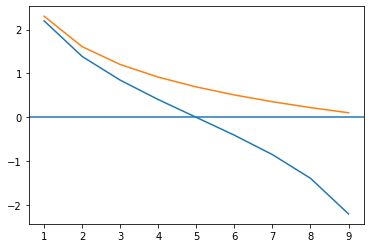

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

N = 10
dfList = np.arange(1, 10, 1)
plt.plot(dfList, [idf4(_) for _ in dfList])
plt.plot(dfList, [idf5(_) for _ in dfList])
plt.axhline(0)
plt.show()

## TF-IDF Weight Schemes
<div align="left">
<table class="wikitable" style="float: top; margin-left: 0; margin-right: 1.5em; margin-top: 0;">
<caption>Recommended tf–idf weighting schemes
</caption>
<tbody><tr>
<th>weighting scheme
</th>
<th>document term weight
</th>
<th>query term weight
</th></tr>
<tr>
<td>1</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/74db3d91105b74e8450a78fadbf7ea7f241bc737" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:11.377ex; height:5.509ex;" alt="{\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mrow>
          <mo>(</mo>
          <mrow>
            <mn>0.5</mn>
            <mo>+</mo>
            <mn>0.5</mn>
            <mrow class="MJX-TeXAtom-ORD">
              <mfrac>
                <msub>
                  <mi>f</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                    <mo>,</mo>
                    <mi>q</mi>
                  </mrow>
                </msub>
                <mrow>
                  <munder>
                    <mo movablelimits="true" form="prefix">max</mo>
                    <mrow class="MJX-TeXAtom-ORD">
                      <mi>t</mi>
                    </mrow>
                  </munder>
                  <msub>
                    <mi>f</mi>
                    <mrow class="MJX-TeXAtom-ORD">
                      <mi>t</mi>
                      <mo>,</mo>
                      <mi>q</mi>
                    </mrow>
                  </msub>
                </mrow>
              </mfrac>
            </mrow>
          </mrow>
          <mo>)</mo>
        </mrow>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fe1629098093a97eb293bd5085009c51c3cdd77b" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.671ex; width:29.854ex; height:6.509ex;" alt="{\displaystyle \left(0.5+0.5{\frac {f_{t,q}}{\max _{t}f_{t,q}}}\right)\cdot \log {\frac {N}{n_{t}}}}"/></span>
</td></tr>
<tr>
<td>2</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle 1+\log f_{t,d}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle 1+\log f_{t,d}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/dc85c57525999f9f224ac5623e606bea2160d171" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -1.005ex; width:10.644ex; height:2.843ex;" alt="1+\log f_{{t,d}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow>
          <mo>(</mo>
          <mrow>
            <mn>1</mn>
            <mo>+</mo>
            <mrow class="MJX-TeXAtom-ORD">
              <mfrac>
                <mi>N</mi>
                <msub>
                  <mi>n</mi>
                  <mrow class="MJX-TeXAtom-ORD">
                    <mi>t</mi>
                  </mrow>
                </msub>
              </mfrac>
            </mrow>
          </mrow>
          <mo>)</mo>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/29f34f3a19a3fec371d5ab2756896a4c3cfc0d96" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.505ex; width:13.453ex; height:6.176ex;" alt="{\displaystyle \log \left(1+{\frac {N}{n_{t}}}\right)}"/></span>
</td></tr>
<tr>
<td>3</td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>d</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/c271425fa07254a10379f1379e02d0fd034f4f21" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:20.548ex; height:5.509ex;" alt="{\displaystyle (1+\log f_{t,d})\cdot \log {\frac {N}{n_{t}}}}"/></span></td>
<td><span class="mwe-math-element"><span class="mwe-math-mathml-inline mwe-math-mathml-a11y" style="display: none;"><math xmlns="http://www.w3.org/1998/Math/MathML"  alttext="{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}">
  <semantics>
    <mrow class="MJX-TeXAtom-ORD">
      <mstyle displaystyle="true" scriptlevel="0">
        <mo stretchy="false">(</mo>
        <mn>1</mn>
        <mo>+</mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <msub>
          <mi>f</mi>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>t</mi>
            <mo>,</mo>
            <mi>q</mi>
          </mrow>
        </msub>
        <mo stretchy="false">)</mo>
        <mo>&#x22C5;<!-- ⋅ --></mo>
        <mi>log</mi>
        <mo>&#x2061;<!-- ⁡ --></mo>
        <mrow class="MJX-TeXAtom-ORD">
          <mfrac>
            <mi>N</mi>
            <msub>
              <mi>n</mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mi>t</mi>
              </mrow>
            </msub>
          </mfrac>
        </mrow>
      </mstyle>
    </mrow>
    <annotation encoding="application/x-tex">{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}</annotation>
  </semantics>
</math></span><img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/cb8cdf7f351b63973cee045cc98c9efcde04203a" class="mwe-math-fallback-image-inline" aria-hidden="true" style="vertical-align: -2.171ex; width:20.445ex; height:5.509ex;" alt="{\displaystyle (1+\log f_{t,q})\cdot \log {\frac {N}{n_{t}}}}"/></span>
</td></tr></tbody></table>
</div>

In [57]:
TWM = defaultdict(lambda: defaultdict(float))
DocLength = defaultdict(float)

for j, docs in TDM.items():
    try:
        IDF1 = idf1(len(docs))
        IDF2 = idf2(len(docs))
        IDF4 = idf4(len(docs))

        for i, f in docs.items():
            TF1 = tf1(f, sum(DTM[i].values()))
            TF2 = tf2(f)
            TF3 = tf3(f, max(DTM[i].values()))

            W1 = f*IDF1
            W2 = TF2*1
            W3 = TF2*IDF1
            W4 = TF3*IDF1

            TWM[j][i] = W4
            DocLength[i] += W4 ** 2
    except:
        continue

- Relvance = Similarity
- euclidean = sqrt(t ㅌ V (q - d_i)**2)
- cos theta = q vector * d_i vector / (|q| 굳이 계산 X) * |d_i|

In [58]:
kkma.nouns('가방 가방 가방')

['가방']

In [59]:
kkma.pos('가방 가방 가방')

[('가방', 'NNG'), ('가방', 'NNG'), ('가방', 'NNG')]

In [60]:
from math import sqrt

# Q = '필로폰 투약 혐의 로버트 할리, 최후 변론서 눈물 아들이 존경했는데'
# Q = '대통령 청와대 국민 정부'
Q = '아베 신조'
_Q = [_[0] for _ in kkma.pos(Q) if _[1].startswith('N') and _[0] in V]

QWM = defaultdict(float)

for t in _Q:
    j = V.index(t)
    QWM[j] += 1

maxFreq = max(QWM.values())

for j in QWM:
    IDF1 = idf1(len(TWM[j]))
    QWM[j] = tf3(QWM[j], maxFreq, 0.5) * idf1(len(TWM[j]))
    
QLength = sqrt(sum([_**2 for _ in QWM.values()]))

In [61]:
QWM

defaultdict(float, {2638: 2.302585092994046, 2639: 2.302585092994046})

In [62]:
searchResult = defaultdict(float)
for q_j, w_q in QWM.items():
    for i, w in TWM[q_j].items():
        searchResult[i] += q_j*i

for i, innerProduct in searchResult.items():
    searchResult[i] = innerProduct / (QLength * sqrt(DocLength[i]))

for _ in sorted(searchResult.items(), key=lambda x: x[1], reverse=True):
    print(_[1])
    print(collection[_[0]])
    print()

327.1667529225466
아베 신조 일본 총리가 지난 3일 도쿄 일본기자클럽에서 열린 당수 토론회에서 물을 마시고 있다 도쿄AFP연합뉴스일본 정부가 한국을 겨냥한 수출 규제 조치를 두고 또다시 앞뒤가 안 맞는 행태를 보이고 있다 북한까지 끌어들여 한국의 전략물자 수출관리 문제를 흔들어대다가 한국 측 반격에 직면하자 맞지 않는 지적이라고 한국 탓을 하고 있다 지난 1일 기습적인 규제 조치 발표 이후 고삐 풀린 듯 공세를 펼치더니 뜻대로 되지 않자 한 발을 빼는 모습이다18일 일본 언론에 따르면 일본 정부는 수출 규제 조치가 안전보장상 수출관리 운용의 재검토로 대항조치가 아니라고 처음부터 일관되게 설명했다고 주장하고 있다 이번 조치가 정치적경제적 동기에 의한 중대한 도전이라는 지난 16일 문재인 대통령의 지적이 틀렸다는 것이다이는 일본 정부가 지난 1일 조치 발표 때 한국이 징용 문제에 대한 만족스러운 해결책을 주요20개국G20 정상회의까지 제시하지 않았다고 사실상 대항조치임을 시인한 것을 뒤집은 것이다 전날 문 대통령 지적은 전혀 맞지 않는다고 정면 반박해 외교 결례 지적을 받은 세코 히로시게 경제산업상도 지난 3일 트위터에 같은 이유를 댔다 일본 정부는 전략물자의 북한 유출설에 대해서도 발을 빼고 있다 고노 다로 외무상은 전날 한국에서 전략물자가 북한에 유출된 의혹이 있다는 것은 일본 정부의 발언이 아니다라고 했다하지만 북한 유출설을 부풀린 것은 일본 정부여당과 일부 일본 언론이다 하기우다 고이치 자민당 간사장 대행은 지난 5일 군사 전용이 가능한 물품이 북한으로 흘러갈 우려가 있다고 했고 보수 성향 후지TV는 에칭가스불화수소를 한국에 수출했는데 행방이 묘연해졌다 행선지는 북한이란 여당 간부의 말을 전했다 하기우다는 아베 신조 총리의 최측근으로 이 정권의 스피커 역할을 하고 있다 아베 총리도 지난 7일 국제 약속을 지키지 않는데 무역관리도 지키지 않을 것이라면서 이번 조치가 한국의 대북제재와 연관된 것임을 시사했다 북한 유출설이 일본 정부 발언이 아니라

In [63]:
searchResult = defaultdict(float)
for t in V:
    j = V.index(t)
    
    for i, w in TWM[j].items():
        searchResult[i] += w**2 # (QWM[j] - w)**2

for i, innerProduct in searchResult.items():
    searchResult[i] = -sqrt(innerProduct)

for _ in sorted(searchResult.items(), key=lambda x: x[1], reverse=True):
    print(_[1], len(collection[_[0]].split()))
    print(collection[_[0]][:30])
    print()

-11.314211693625687 122
일본 불매 운동 포스터 사진온라인 커뮤니티국민의 자발적

-14.424043124435244 138
듀얼스크린 동시 작업게임에 유용갤폴드메이트X 대비 가격

-15.590973956522552 139
동영상 뉴스주영진의 뉴스브리핑인터뷰를 인용보도할 때는 

-16.172271126101986 221
머니투데이 김수현 기자 1위 베이조스에 이어 2위 아르

-16.219894423652313 207
제약바이오업계 숙원인 첨단 재생의료 및 첨단 바이오의약

-17.24138503476881 515
고민정 청와대 대변인 뉴시스청와대가 17일 한국을 겨냥

-17.24138503476881 515
고민정 청와대 대변인 뉴시스청와대가 17일 한국을 겨냥

-17.661922220900216 240
조선DB남편을 청부살해하고 강도 사건으로 위장한 혐의로

-17.884383937150318 362
회견서 밝혀윤순구 스틸웰 대화재개 통한 한일갈등 해결 

-18.044720531126014 265
17일 표창원 의원 이어 피고발인 신분으로 출석CBS노

-18.33311794316867 250
근로감독 결과 갈 길 먼 드라마 제작현장게티이미지뱅크K

-18.578975239175175 220
일진복합소재 매연저감장치DPF 사진일진복합소재일진복합소

-18.997474354643245 298
스틸웰 국무부 차관보 한일 관계 개선 희망 언급문제 해

-19.619506436240275 405
이종명 제명 확정지을 의원총회도 시간 걸릴 듯17일 오

-20.36952623820976 299
17일 하현회 LG유플러스 부회장이 서울 용산구 LG유

-20.527572556756095 346
손석한 정신과 전문의 라디오 인터뷰뉴시스고 정두언 전 

-20.56619519855114 293
정부가 민간택지에서 짓는 아파트에 대해 분양가 상한제 

-21.10539081888618 301
식용 곤충 고소애가 암 수술 환자의 영양상태 개선과 면